In [1]:
!python --version

Python 3.7.16


In [2]:
import os
os.chdir("..")
from rice import Rice
import torch
import numpy as np

from tqdm import tqdm

import copy

from PPO_copied import ActorCritic, PPO, RolloutBuffer

In [3]:
env = Rice(region_yamls_filename='fewer_region_yamls/')

In [4]:
def create_agents(env : Rice):
    agents = []
    initial_state = env.reset()
    for i in range(env.num_regions):
        agents.append(
            PPO(
                state_dim = len(initial_state[i]['features']), 
                action_dim = env.action_space[i]
            )
        )
    return agents

In [5]:
agents = create_agents(env)

In [6]:
epochs = 100
batch_size = 8

In [7]:
for epoch in tqdm(range(epochs)):
    for batch in range(batch_size):
        state = env.reset()
        for t in range(env.episode_length):
            collective_action = {}
            for agent_id in range(len(agents)):
                collective_action[agent_id] = agents[agent_id].select_action(state[agent_id])
            state, reward, _, _ = env.step(collective_action)
            for agent_id in range(len(agents)):
                agents[agent_id].buffer.rewards.append(reward[agent_id])
                agents[agent_id].buffer.is_terminals.append(t == env.episode_length - 1)
            
    for agent in agents:
        agent.update()

100%|█████████████████████████████████████████| 100/100 [03:28<00:00,  2.08s/it]


In [8]:
def evaluate_agents(agents):
    state = env.reset()
    actions = {i : [] for i in range(len(agents))}
    for t in range(env.episode_length):
        collective_action = {}
        for agent_id in range(len(agents)):
            action = agents[agent_id].select_action(state[agent_id])
            collective_action[agent_id] = action
            actions[agent_id].append(action)
        state, reward, _, _ = env.step(collective_action)
    return copy.deepcopy(env.global_state), actions

In [9]:
def baseline():
    return evaluate_agents(create_agents(env))

In [12]:
t, a = evaluate_agents(agents)
b, a1 = baseline()

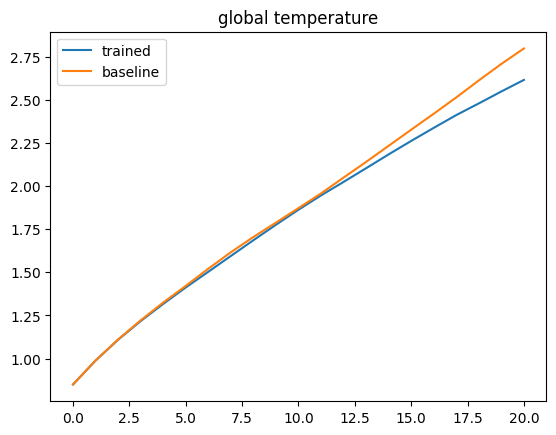

In [14]:
import matplotlib.pyplot as plt
plt.plot(t['global_temperature']['value'][:, 0], label = 'trained')
plt.plot(b['global_temperature']['value'][:, 0], label = 'baseline')
plt.legend()
plt.title('global temperature')
plt.show()